In [1]:
#### ECE 684 Final Project
#### Author: Ling Lei, Qingyang Yu, Yushan Shi

# Section A: Load data, explore the basic statistics and data cleaning
# import package
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    adjusted_rand_score,
    classification_report,
    normalized_mutual_info_score,
    silhouette_score
)
from sklearn.decomposition import PCA
from scipy.sparse import csgraph, csr_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# some statistics
# will be used in the writeup for data section
data_path = r"testdata-taskB-all-annotations.txt"

df = pd.read_csv(data_path, sep="\t", encoding="utf-8")

print("Raw data shape:", df.shape)
print("Columns:", df.columns.tolist())
print("-"*50)

# note that there is no NA values
print("NA counts per column:")
print(df.isna().sum())
print("-"*50)

# Some statistical results
# value_counts
rows = []
for col in ['Target','Stance','Opinion towards','Sentiment']:
    vc = df[col].value_counts()
    for k,v in vc.items():
        rows.append([col, k, v])

clean = pd.DataFrame(rows, columns=['Category','Value','Count'])
print(clean.to_string(index=False))

print("-"*50)

# cross table for Stance, Opinion towards, Sentiment
# Stance and Opinion
tab1 = pd.crosstab(
    [ df["Stance"]],
    df["Opinion towards"] ,
    margins=True
)

print(tab1)
print("-"*45)

# Stance and Opinion towards
tab2 = pd.crosstab(
    [ df["Sentiment"]],
    df["Opinion towards"] ,
    margins=True
)

print(tab2)
print("-"*50)

mask1 = (df["Stance"] == "FAVOR") & (df["Sentiment"] == "NEGATIVE")
mask2 = (df["Stance"] == "AGAINST") & (df["Sentiment"] == "POSITIVE")
df_support_negative = df[mask1]
df_against_positive = df[mask2]

# some example for the data section,
# note that we should explain why we can allow the tance and sentiment being apart
print(df_support_negative[['Tweet']].head(3).to_string())
print(df_against_positive[['Tweet']].head(3).to_string())

Raw data shape: (707, 6)
Columns: ['ID', 'Target', 'Tweet', 'Stance', 'Opinion towards', 'Sentiment']
--------------------------------------------------
NA counts per column:
ID                 0
Target             0
Tweet              0
Stance             0
Opinion towards    0
Sentiment          0
dtype: int64
--------------------------------------------------
       Category        Value  Count
         Target Donald Trump    707
         Stance      AGAINST    299
         Stance         NONE    260
         Stance        FAVOR    148
Opinion towards        OTHER    356
Opinion towards       TARGET    324
Opinion towards       NO ONE     27
      Sentiment     NEGATIVE    481
      Sentiment     POSITIVE    193
      Sentiment      NEITHER     33
--------------------------------------------------
Opinion towards  NO ONE  OTHER  TARGET  All
Stance                                     
AGAINST               1    122     176  299
FAVOR                 0      3     145  148
NONE        

In [2]:
#   tweet cleaning. Removing: URLs, @mentions, '#' and whitespace.
# note that we will include the table to explain in appendix what we have done for the tweet clean step.
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

cols_keep = ["ID", "Target", "Tweet", "Stance"] # noet that we will only use the extra infor from stance col
df = df[cols_keep].dropna(subset=["Tweet", "Stance"])


# the projetc we will focus only on favor and against two stance, remove none
df = df[df["Target"] == "Donald Trump"]

valid_labels = ["FAVOR", "AGAINST"]
df["Stance"] = df["Stance"].str.upper()
df = df[df["Stance"].isin(valid_labels)]

df["stance_binary"] = (df["Stance"] == "FAVOR").astype(int)

# clean and do some check, the table should be attached to appendix.
df["clean_text"] = df["Tweet"].apply(preprocess_text)
df = df.reset_index(drop=True)

print("\nCleaned data shape:", df.shape)
print("\nFirst 5 cleaned rows:")
display(df.head())

print("\nStance distribution (Donald Trump, FAVOR vs AGAINST):")
print(df["Stance"].value_counts())

print(df[["ID", "clean_text"]].head(15).to_string())


Cleaned data shape: (447, 6)

First 5 cleaned rows:


,ID,Target,Tweet,Stance,stance_binary,clean_text
0,20004,Donald Trump,@ABC Stupid is as stupid does! Showedhis true ...,AGAINST,0,stupid is as stupid does! showedhis true color...
1,20006,Donald Trump,Donald Trump isn't afraid to roast everyone. #...,FAVOR,1,donald trump isn't afraid to roast everyone. s...
2,20007,Donald Trump,Donald Trump for president? I can dig it. #SemST,FAVOR,1,donald trump for president? i can dig it. semst
3,20011,Donald Trump,@USAlivestrong @scottscameron @ljmljm55 @blond...,FAVOR,1,100% support trump.. semst
4,20013,Donald Trump,Considering the fact that Bush was a president...,FAVOR,1,considering the fact that bush was a president...



Stance distribution (Donald Trump, FAVOR vs AGAINST):
Stance
AGAINST    299
FAVOR      148
Name: count, dtype: int64
       ID                                                                                                                        clean_text
0   20004      stupid is as stupid does! showedhis true colors; seems that he ignores that us was invaded, & plundered,not discovered semst
1   20006                                                                                donald trump isn't afraid to roast everyone. semst
2   20007                                                                                   donald trump for president? i can dig it. semst
3   20011                                                                                                        100% support trump.. semst
4   20013  considering the fact that bush was a president of this country, i don't see it a joke that trump is running ! election2016 semst
5   20017                                 

In [4]:
# !pip install gensim
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install -U transformers
# !pip install -U sentence-transformers

In [5]:
# Section B: do the  Sentence-BERT embeddings for cleaned data

# embedding to the bert semantic space
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

texts = df["clean_text"].tolist()

X_bert = bert_model.encode(
    texts,
    show_progress_bar=True
)

X_bert = np.array(X_bert)

print("BERT embedding shape:", X_bert.shape)


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

BERT embedding shape: (447, 384)



===================== train_ratio r = 0.1 (test_size = 0.9) =====================

Train size: 44 Test size: 403
Affinity (BERT-only, test set) shape: (403, 403)
Affinity stats: min: 0.99427223 max: 1.0 mean: 0.99626905


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.10
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0348  
Fiedler $\lambda_2$:    1.0023 
Modularity Q:   0.0001  


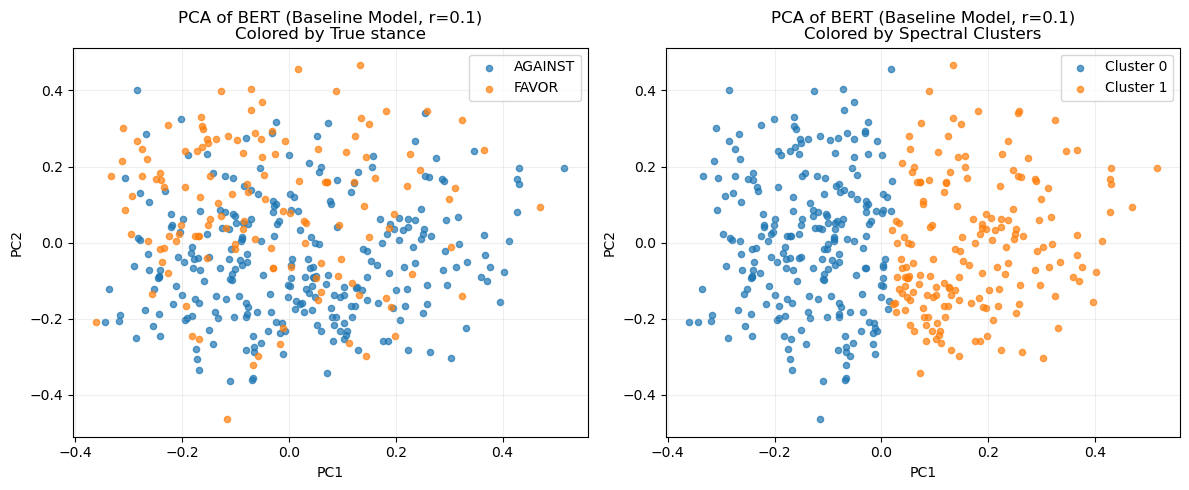


===================== train_ratio r = 0.2 (test_size = 0.8) =====================

Train size: 89 Test size: 358
Affinity (BERT-only, test set) shape: (358, 358)
Affinity stats: min: 0.99427223 max: 1.0 mean: 0.9962695

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.20
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0354  
Fiedler $\lambda_2$:    1.0026 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


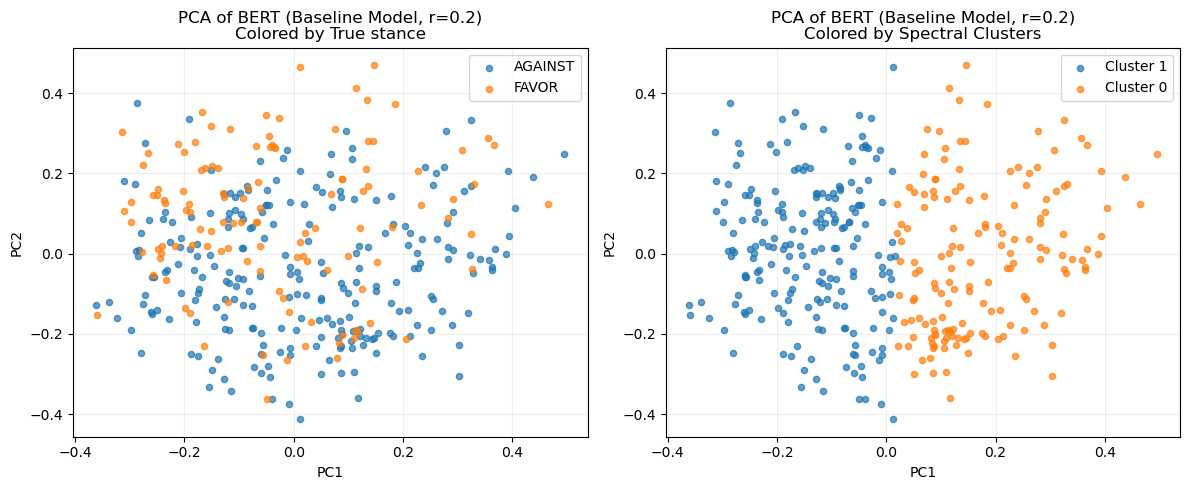


===================== train_ratio r = 0.3 (test_size = 0.7) =====================

Train size: 134 Test size: 313
Affinity (BERT-only, test set) shape: (313, 313)
Affinity stats: min: 0.99427223 max: 1.0 mean: 0.996267

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.30
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0357  
Fiedler $\lambda_2$:    1.0030 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


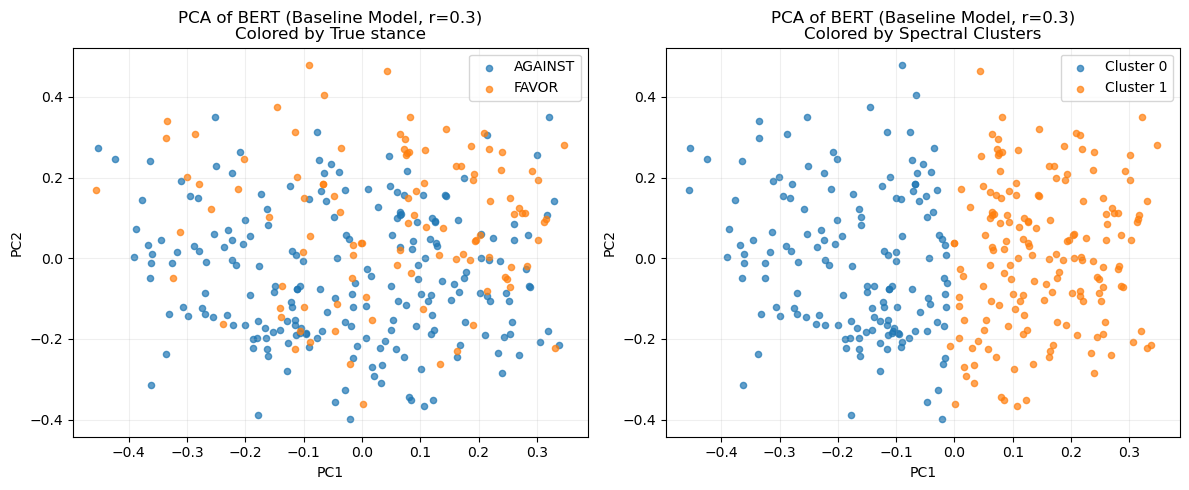


===================== train_ratio r = 0.4 (test_size = 0.6) =====================

Train size: 178 Test size: 269
Affinity (BERT-only, test set) shape: (269, 269)
Affinity stats: min: 0.99427223 max: 1.0 mean: 0.9962835

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.40
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0379  
Fiedler $\lambda_2$:    1.0035 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


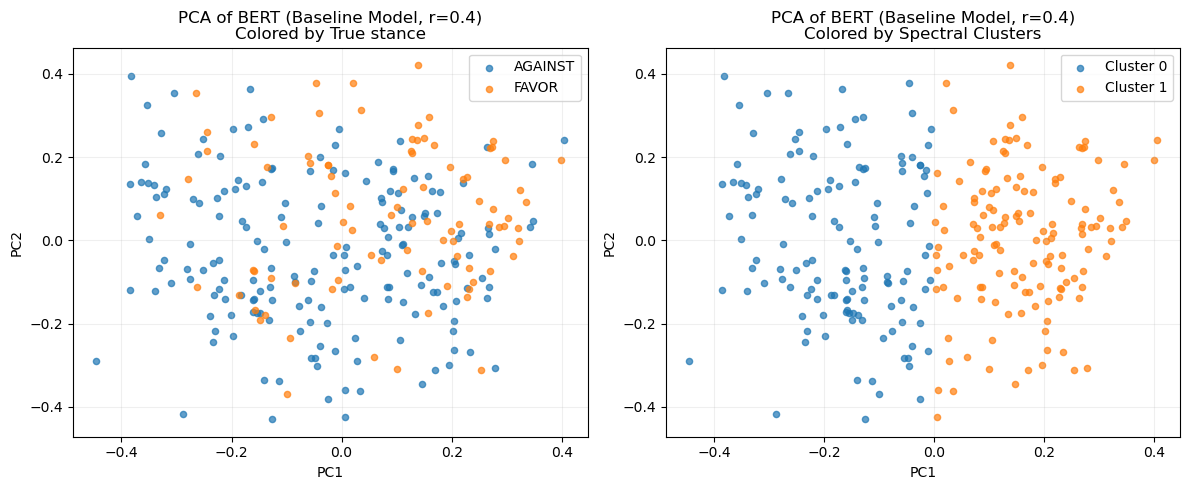


===================== train_ratio r = 0.5 (test_size = 0.5) =====================

Train size: 223 Test size: 224
Affinity (BERT-only, test set) shape: (224, 224)
Affinity stats: min: 0.99427223 max: 1.0 mean: 0.9962725

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.50
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0393  
Fiedler $\lambda_2$:    1.0043 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


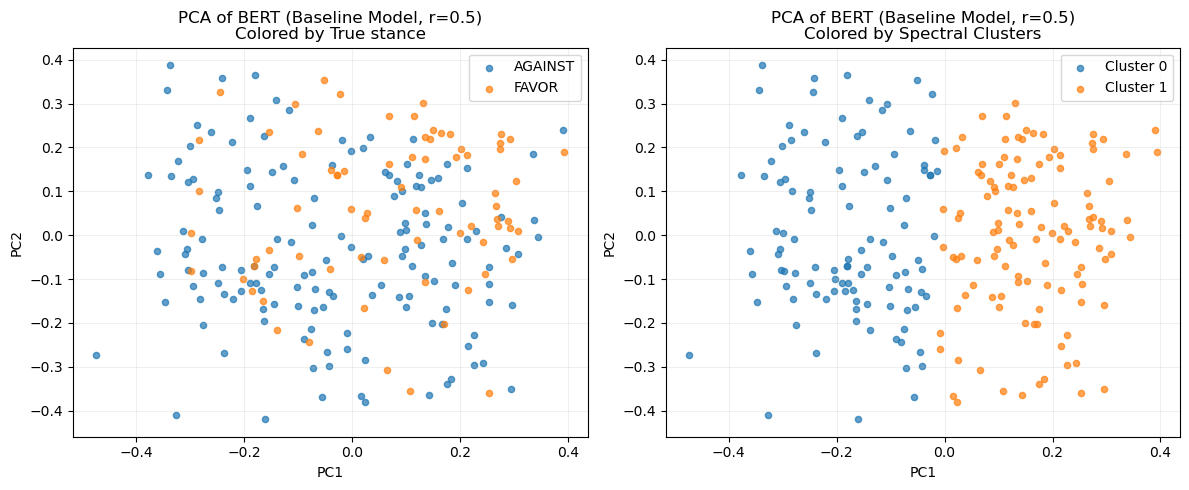


===================== train_ratio r = 0.6 (test_size = 0.4) =====================

Train size: 268 Test size: 179
Affinity (BERT-only, test set) shape: (179, 179)
Affinity stats: min: 0.9944935 max: 1.0 mean: 0.99628454

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.60
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0411  
Fiedler $\lambda_2$:    1.0054 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


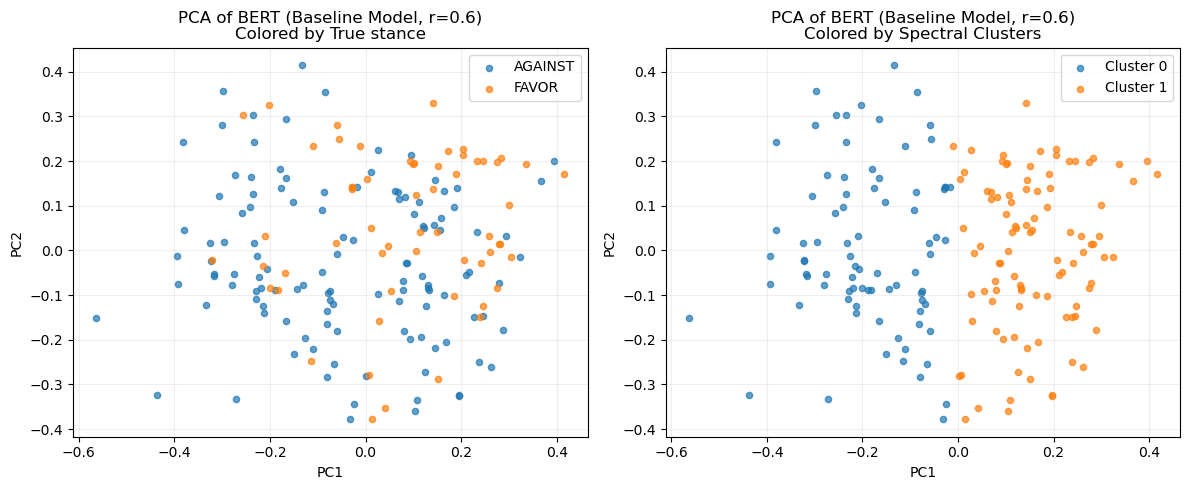


===================== train_ratio r = 0.7 (test_size = 0.3) =====================

Train size: 312 Test size: 135
Affinity (BERT-only, test set) shape: (135, 135)
Affinity stats: min: 0.9944935 max: 1.0 mean: 0.99624604

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.70
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0419  
Fiedler $\lambda_2$:    1.0073 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


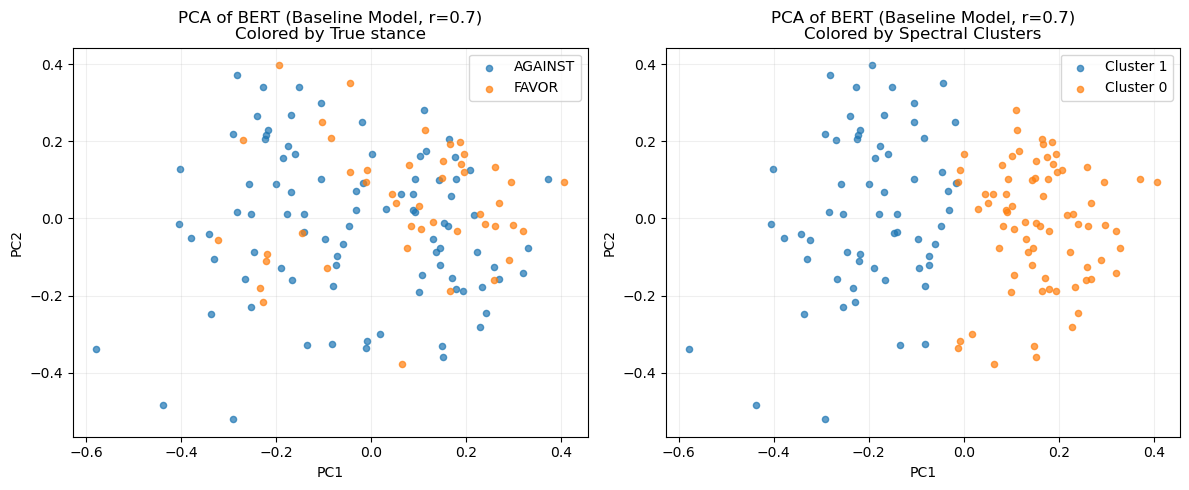


===================== train_ratio r = 0.8 (test_size = 0.2) =====================

Train size: 357 Test size: 90
Affinity (BERT-only, test set) shape: (90, 90)
Affinity stats: min: 0.9944935 max: 1.0 mean: 0.9962321

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.80
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0434  
Fiedler $\lambda_2$:    1.0110 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


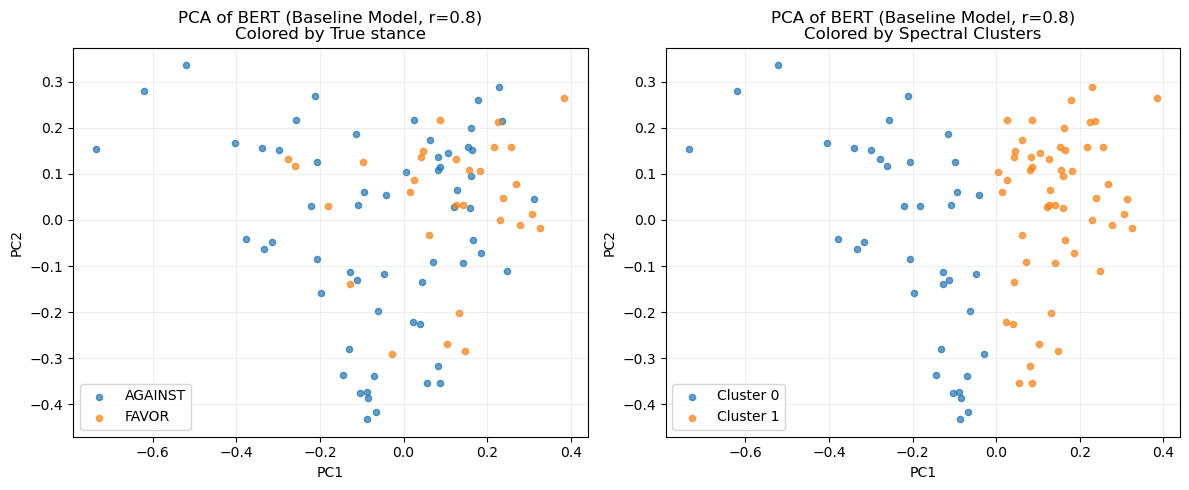


===================== train_ratio r = 0.9 (test_size = 0.1) =====================

Train size: 402 Test size: 45
Affinity (BERT-only, test set) shape: (45, 45)
Affinity stats: min: 0.994575 max: 1.0 mean: 0.9961949

=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===
Train ratio r:0.90
Cluster and stance mapping (unsupervised baseline): {np.int32(0): 0, np.int32(1): 0}

--- Polarization Metrics ---
Silhouette score: 0.0605  
Fiedler $\lambda_2$:    1.0225 
Modularity Q:   0.0001  


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


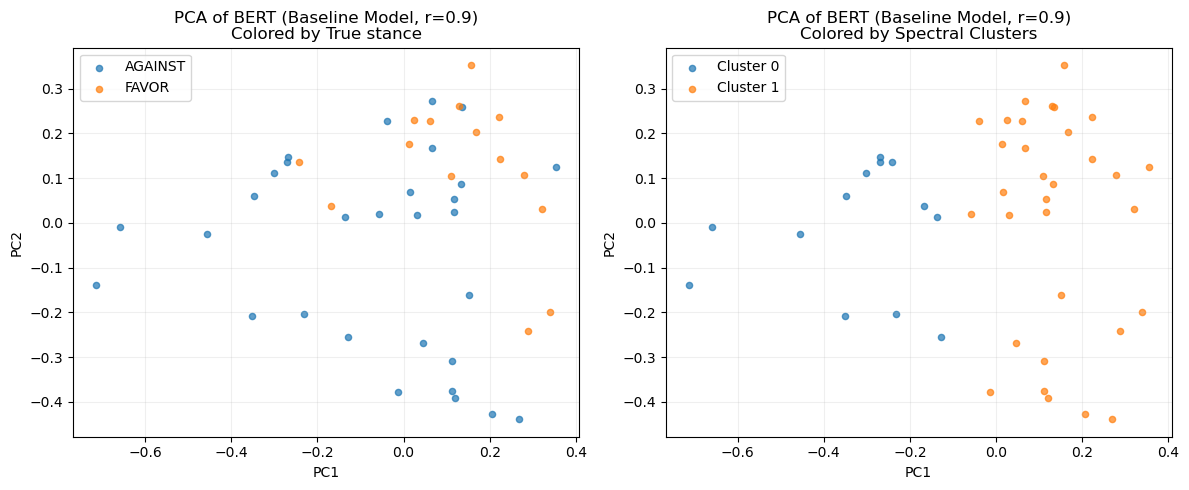

In [6]:
# Section C: baseline model.
# only use the pure embedding and see if the the space can separate in its own structure

label_map = {'AGAINST': 0, 'FAVOR': 1}
y = df["Stance"].map(label_map).values

train_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # change the ratios and see how results look

results = []

for r in train_ratios:
    test_size = 1.0 - r
    print(f"\n===================== train_ratio r = {r:.1f} (test_size = {test_size:.1f}) =====================\n")

    X_train, X_test, y_train, y_test = train_test_split( # split, someone writes this part should mention how results changes
        X_bert,   # wrt to the training size
        y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )

    print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


    # rbf transformation
    gamma = 1.0 / X_test.shape[1]
    A_test = rbf_kernel(X_test, gamma=gamma)

    print("Affinity (BERT-only, test set) shape:", A_test.shape)
    print("Affinity stats:",
          "min:", A_test.min(),
          "max:", A_test.max(),
          "mean:", A_test.mean())

    # clustering
    spec_test = SpectralClustering(
        n_clusters=2,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=42
    )
    cluster_test = spec_test.fit_predict(A_test)


    # define the  majority vote, for check whether this space construction works or not
    mapping_unsup = {}
    y_pred_unsup = np.zeros_like(cluster_test)

    for c in np.unique(cluster_test):
        mask = (cluster_test == c)
        majority = (y_test[mask].mean() > 0.5)  # True -> label 1 (FAVOR)
        mapping_unsup[c] = int(majority)
        y_pred_unsup[mask] = mapping_unsup[c]

    acc_unsup = accuracy_score(y_test, y_pred_unsup)
    ari_unsup = adjusted_rand_score(y_test, cluster_test)
    nmi_unsup = normalized_mutual_info_score(y_test, cluster_test)


    # 3 scores: Silhouette, Fiedler eigenvalue λ2 and modularity Q
    # create a table to report. this is the main resulst to explain
    sil_unsup = silhouette_score(X_test, cluster_test, metric="euclidean")

    L_test = csgraph.laplacian(csr_matrix(A_test), normed=True)
    eigvals_test, _ = eigsh(L_test, k=3, which="SM")
    lambda2_unsup = float(np.sort(eigvals_test)[1])

    k = A_test.sum(axis=1)
    m = A_test.sum() / 2.0
    B = A_test - np.outer(k, k) / (2.0 * m)
    same_cluster = (cluster_test[:, None] == cluster_test[None, :])
    Q_unsup = (B * same_cluster).sum() / (2.0 * m)

    print("\n=== Unsupervised Spectral Clustering on TEST (Baseline semantic space) ===")
    print(f"Train ratio r:{r:.2f}")
    # note this part will hold until we have feedbacks
    # do not report yet.
    # print(f"Accuracy (reference only): {acc_unsup:.4f}")
    # print(f"ARI (reference only):   {ari_unsup:.4f}")
    # print(f"NMI (reference only):    {nmi_unsup:.4f}")
    print("Cluster and stance mapping (unsupervised baseline):", mapping_unsup)

    print("\n--- Polarization Metrics ---")
    print(f"Silhouette score: {sil_unsup:.4f}  ")
    print(f"Fiedler $\lambda_2$:    {lambda2_unsup:.4f} ")
    print(f"Modularity Q:   {Q_unsup:.4f}  ")

    results.append({
        "r": r,
        "silhouette": sil_unsup,
        "lambda2": lambda2_unsup,
        "Q": Q_unsup,
        "acc": acc_unsup,
        "ari": ari_unsup,
        "nmi": nmi_unsup
    })


    # PCA visualization of TEST embeddings
    pca_test = PCA(n_components=2, random_state=42)
    X_test_2d = pca_test.fit_transform(X_test)

    colors = {0: "tab:blue", 1: "tab:orange"}
    label_names = {0: "AGAINST", 1: "FAVOR"}

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for lab in [0, 1]:
        mask = (y_test == lab)
        plt.scatter(
            X_test_2d[mask, 0], X_test_2d[mask, 1],
            s=20, alpha=0.7, c=colors[lab], label=label_names[lab]
        )
    plt.title(f"PCA of BERT (Baseline Model, r={r:.1f})\nColored by True stance")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(alpha=0.2)

    cluster_labels = np.unique(cluster_test)
    pc1_means = {c: X_test_2d[cluster_test == c, 0].mean() for c in cluster_labels}

    left_cluster = min(pc1_means, key=pc1_means.get)
    right_cluster = max(pc1_means, key=pc1_means.get)

    cluster_color_map = {
        left_cluster:  "tab:blue",
        right_cluster: "tab:orange"
    }

    plt.subplot(1, 2, 2)
    for c in [left_cluster, right_cluster]:
        mask = (cluster_test == c)
        plt.scatter(
            X_test_2d[mask, 0], X_test_2d[mask, 1],
            s=20, alpha=0.7, c=cluster_color_map[c],
            label=f"Cluster {c}"
        )

    plt.title(f"PCA of BERT (Baseline Model, r={r:.1f})\nColored by Spectral Clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


In [7]:
# Section D: Add extra info of stance. We will use logistic to process this information

# train logistic model
clf = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    solver="liblinear"
)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

print("\n=== Supervised Logistic Regression on BERT (TEST) ===")
print("Test accuracy (reference only):", accuracy_score(y_test, y_test_pred))
print("\nClassification report (reference only):")
print(classification_report(y_test, y_test_pred, target_names=["AGAINST", "FAVOR"]))

w = clf.coef_[0]
b = clf.intercept_[0]

w = w / np.linalg.norm(w) #normalize

print("\nStance direction vector w extracted. Norm after normalization:", np.linalg.norm(w))

stance_scores_test = X_test @ w   # (n_test,)

print("\nStance score stats on TEST (projection onto w):")
print("min:", stance_scores_test.min())
print("max:", stance_scores_test.max())
print("mean:", stance_scores_test.mean())
print("std:", stance_scores_test.std())



=== Supervised Logistic Regression on BERT (TEST) ===
Test accuracy (reference only): 0.7333333333333333

Classification report (reference only):
              precision    recall  f1-score   support

     AGAINST       0.71      1.00      0.83        30
       FAVOR       1.00      0.20      0.33        15

    accuracy                           0.73        45
   macro avg       0.86      0.60      0.58        45
weighted avg       0.81      0.73      0.67        45


Stance direction vector w extracted. Norm after normalization: 1.0

Stance score stats on TEST (projection onto w):
min: -0.11565645494457577
max: 0.3455161038030532
mean: 0.09793121505248982
std: 0.10203238786254334


d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 22.
  warnings.warn(



================ Supervised stance dim: train_ratio r = 0.1 (test_size = 0.9) ===============

Train size: 44 Test size: 403
Augmented TEST embedding shape: (403, 385)
Affinity stats: min: 0.2720339395546989 max: 1.0 mean: 0.9221872635390859

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.10

--- Polarization Metrics ---
Silhouette score: 0.5274
Fiedler $\lambda_2$:        0.9249
Modularity Q:      0.0259


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


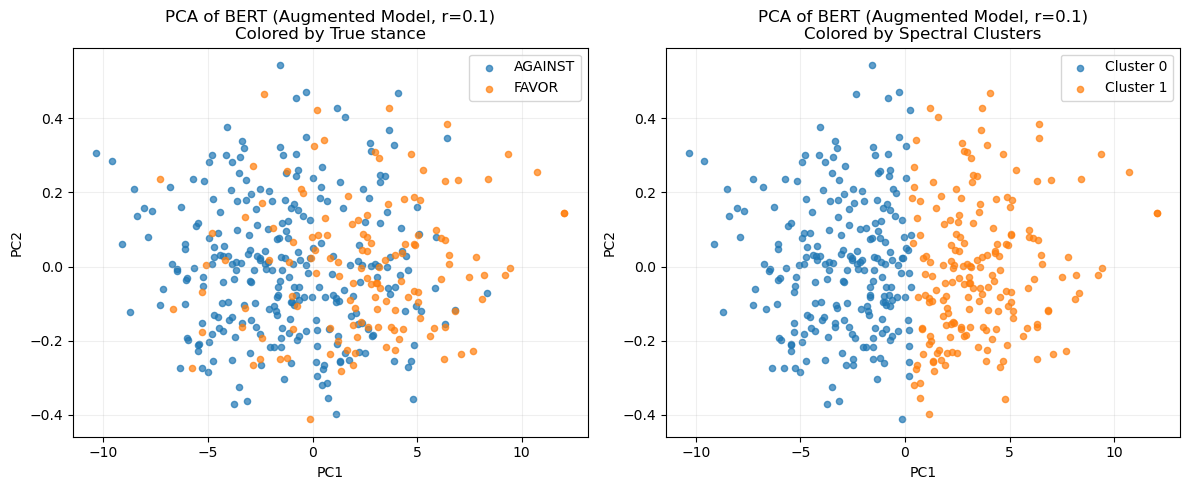


================ Supervised stance dim: train_ratio r = 0.2 (test_size = 0.8) ===============

Train size: 89 Test size: 358
Augmented TEST embedding shape: (358, 385)
Affinity stats: min: 0.39835986622142466 max: 1.0 mean: 0.921854552642726

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.20

--- Polarization Metrics ---
Silhouette score: 0.5426
Fiedler $\lambda_2$:        0.9244
Modularity Q:      0.0266


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


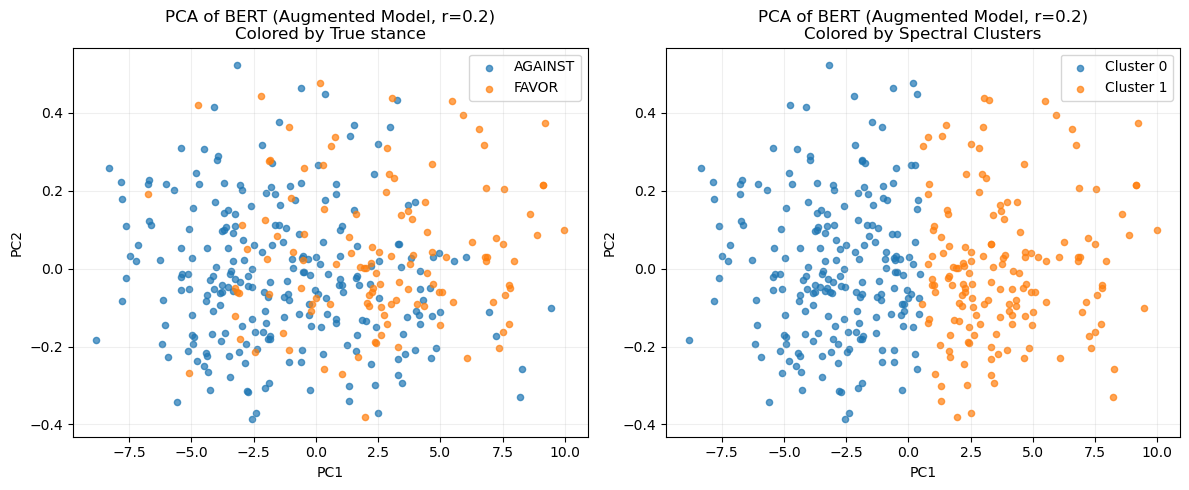


================ Supervised stance dim: train_ratio r = 0.3 (test_size = 0.7) ===============

Train size: 134 Test size: 313
Augmented TEST embedding shape: (313, 385)
Affinity stats: min: 0.38130484042624574 max: 1.0 mean: 0.9220219719628937

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.30

--- Polarization Metrics ---
Silhouette score: 0.5369
Fiedler $\lambda_2$:        0.9250
Modularity Q:      0.0251


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


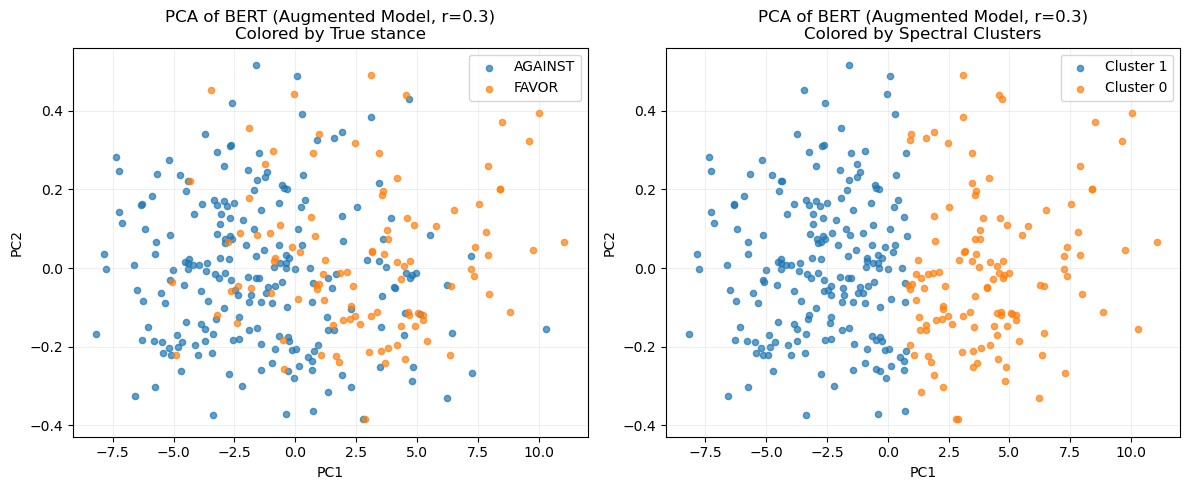


================ Supervised stance dim: train_ratio r = 0.4 (test_size = 0.6) ===============

Train size: 178 Test size: 269
Augmented TEST embedding shape: (269, 385)
Affinity stats: min: 0.37297534876396427 max: 1.0 mean: 0.9219407633940335

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.40

--- Polarization Metrics ---
Silhouette score: 0.5500
Fiedler $\lambda_2$:        0.9252
Modularity Q:      0.0259


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


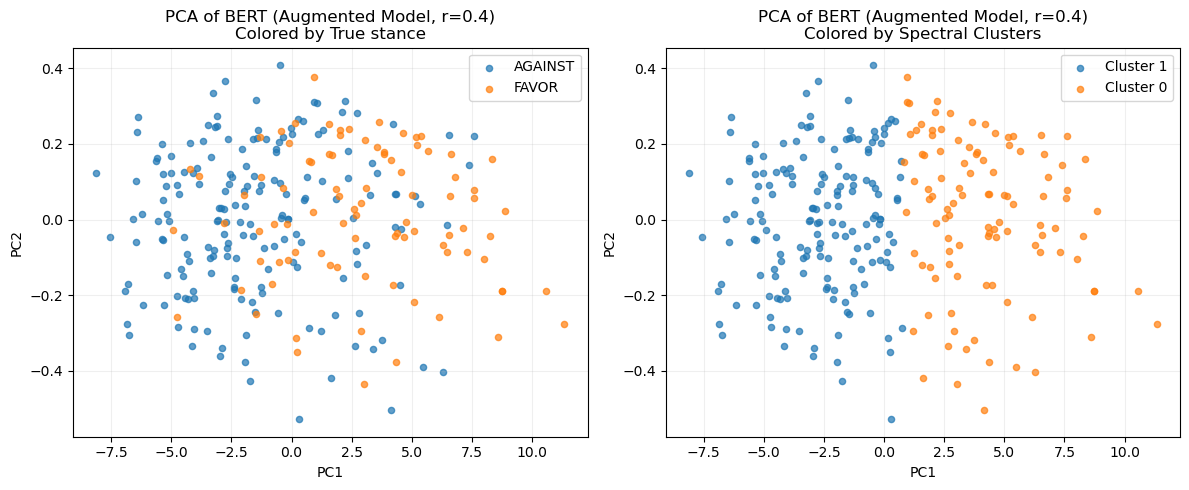


================ Supervised stance dim: train_ratio r = 0.5 (test_size = 0.5) ===============

Train size: 223 Test size: 224
Augmented TEST embedding shape: (224, 385)
Affinity stats: min: 0.4858495630264084 max: 1.0 mean: 0.9215438123598566

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.50

--- Polarization Metrics ---
Silhouette score: 0.5395
Fiedler $\lambda_2$:        0.9253
Modularity Q:      0.0265


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


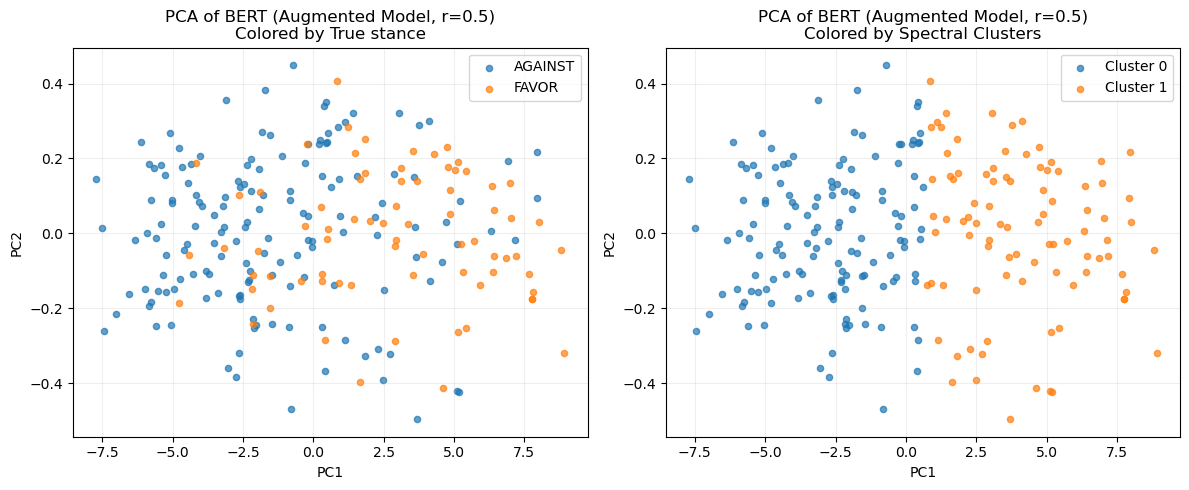


================ Supervised stance dim: train_ratio r = 0.6 (test_size = 0.4) ===============

Train size: 268 Test size: 179
Augmented TEST embedding shape: (179, 385)
Affinity stats: min: 0.5044600620567571 max: 1.0 mean: 0.9216166438914387

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.60

--- Polarization Metrics ---
Silhouette score: 0.5584
Fiedler $\lambda_2$:        0.9265
Modularity Q:      0.0265


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


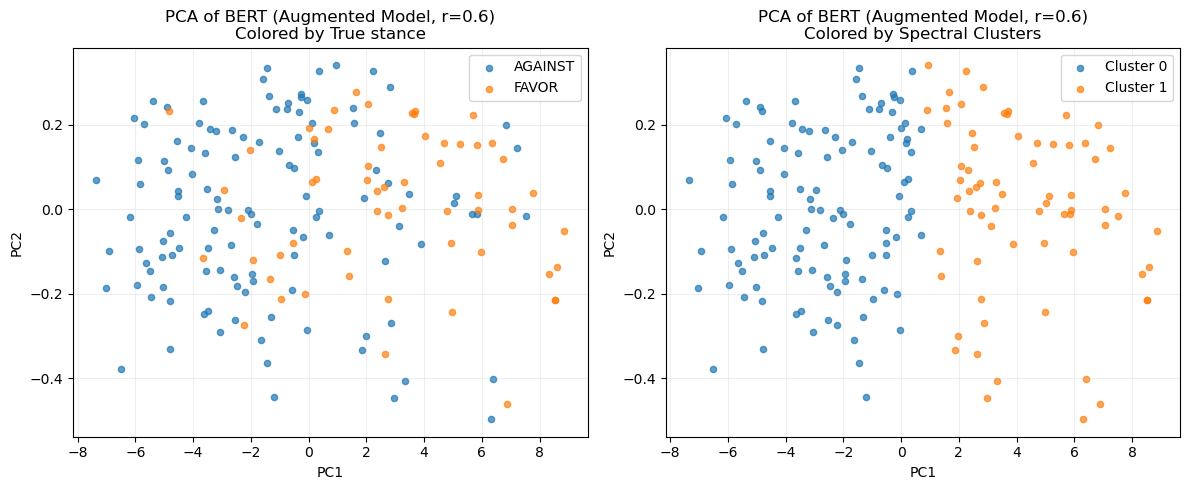


================ Supervised stance dim: train_ratio r = 0.7 (test_size = 0.3) ===============

Train size: 312 Test size: 135
Augmented TEST embedding shape: (135, 385)
Affinity stats: min: 0.48966647304291416 max: 1.0 mean: 0.9216414397841921

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.70

--- Polarization Metrics ---
Silhouette score: 0.5558
Fiedler $\lambda_2$:        0.9286
Modularity Q:      0.0269


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


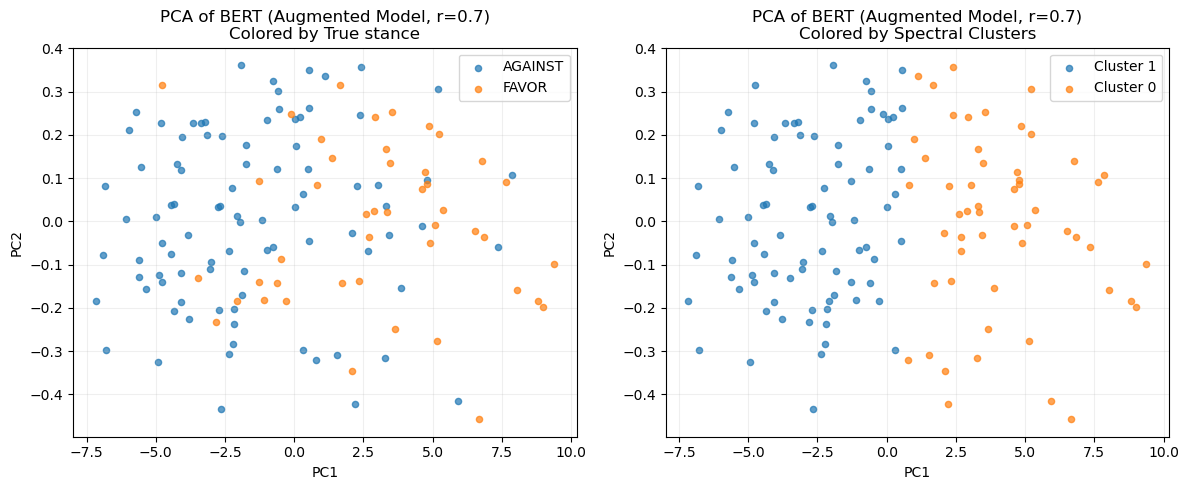


================ Supervised stance dim: train_ratio r = 0.8 (test_size = 0.2) ===============

Train size: 357 Test size: 90
Augmented TEST embedding shape: (90, 385)
Affinity stats: min: 0.4809776499943853 max: 1.0 mean: 0.9219724385427371

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.80

--- Polarization Metrics ---
Silhouette score: 0.5472
Fiedler $\lambda_2$:        0.9331
Modularity Q:      0.0255


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


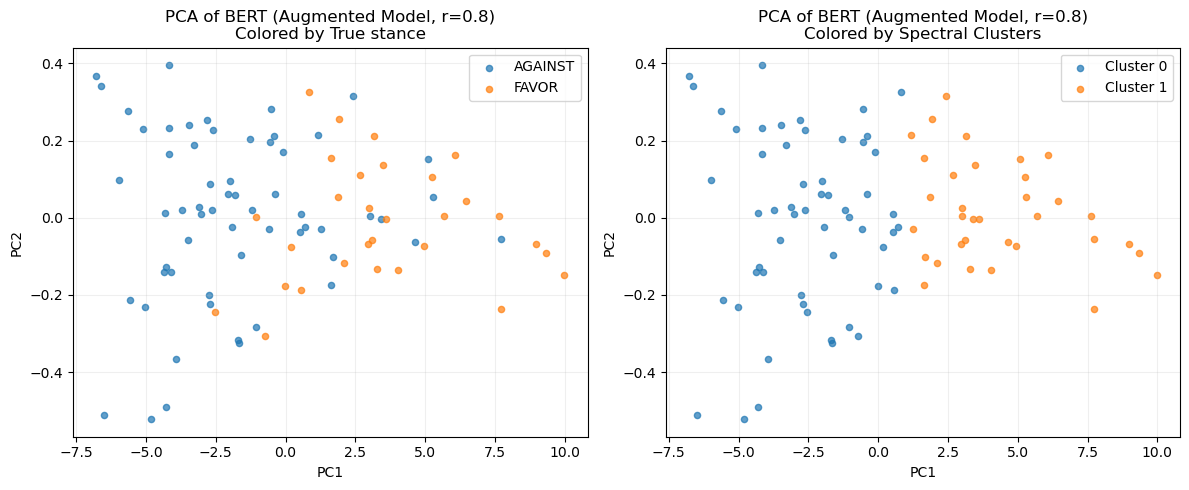


================ Supervised stance dim: train_ratio r = 0.9 (test_size = 0.1) ===============

Train size: 402 Test size: 45
Augmented TEST embedding shape: (45, 385)
Affinity stats: min: 0.44580919655021173 max: 1.0 mean: 0.9226890925471112

=== Spectral Clustering on TEST [BERT + supervised stance dim] ===
Train ratio r: 0.90

--- Polarization Metrics ---
Silhouette score: 0.5030
Fiedler $\lambda_2$:        0.9475
Modularity Q:      0.0242


d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


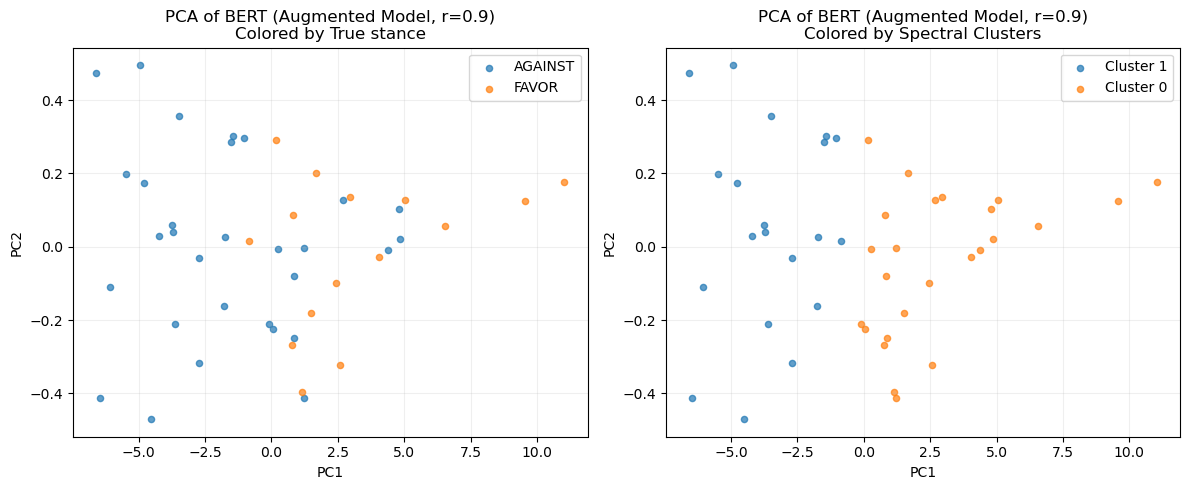

In [8]:
# Section E: do the clustering again using the new info
label_map = {'AGAINST': 0, 'FAVOR': 1}
y = df["Stance"].map(label_map).values

train_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sup_results = []

for r in train_ratios:
    test_size = 1.0 - r
    print(f"\n================ Supervised stance dim: train_ratio r = {r:.1f} (test_size = {test_size:.1f}) ===============\n")

    X_train, X_test, y_train, y_test = train_test_split( # split
        X_bert,
        y,
        test_size=test_size,
        random_state=42,
        stratify=y
    )
    print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

    clf = LogisticRegression(max_iter=2000) # fit the logictics
    clf.fit(X_train, y_train)

    p_favor_test = clf.predict_proba(X_test)[:, 1]

    #standadize
    p_z = (p_favor_test - p_favor_test.mean()) / (p_favor_test.std() + 1e-8)
    stance_dim_test = (4.0 * p_z).reshape(-1, 1)

    X_test_aug = np.hstack([X_test, stance_dim_test])
    print("Augmented TEST embedding shape:", X_test_aug.shape)

    gamma = 1.0 / X_test_aug.shape[1] # rbf
    A_test_aug = rbf_kernel(X_test_aug, gamma=gamma)

    print("Affinity stats:",
          "min:", A_test_aug.min(),
          "max:", A_test_aug.max(),
          "mean:", A_test_aug.mean())

    # clustering
    spec_sup_test = SpectralClustering(
        n_clusters=2,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=42
    )
    cluster_sup_test = spec_sup_test.fit_predict(A_test_aug)

    mapping_sup = {}
    y_pred_sup = np.zeros_like(cluster_sup_test)

    for c in np.unique(cluster_sup_test):
        mask = (cluster_sup_test == c)
        majority = (y_test[mask].mean() > 0.5)
        mapping_sup[c] = int(majority)
        y_pred_sup[mask] = mapping_sup[c]

    acc_sup = accuracy_score(y_test, y_pred_sup)
    ari_sup = adjusted_rand_score(y_test, cluster_sup_test)
    nmi_sup = normalized_mutual_info_score(y_test, cluster_sup_test)

    print("\n=== Spectral Clustering on TEST [BERT + supervised stance dim] ===")
    print(f"Train ratio r: {r:.2f}")
    # print(f"Accuracy (reference only): {acc_sup:.4f}")
    # print(f"ARI (reference only):      {ari_sup:.4f}")
    # print(f"NMI (reference only):      {nmi_sup:.4f}")
    # print("Cluster → stance mapping:", mapping_sup)

    # report part
    sil_sup = silhouette_score(X_test_aug, cluster_sup_test, metric="euclidean")

    L_sup = csgraph.laplacian(csr_matrix(A_test_aug), normed=True)
    eigvals_sup, _ = eigsh(L_sup, k=3, which="SM")
    lambda2_sup = float(np.sort(eigvals_sup)[1])
    k_deg = A_test_aug.sum(axis=1)
    m = A_test_aug.sum() / 2.0
    B = A_test_aug - np.outer(k_deg, k_deg) / (2.0 * m)
    same_cluster = (cluster_sup_test[:, None] == cluster_sup_test[None, :])
    Q_sup = (B * same_cluster).sum() / (2.0 * m)

    print("\n--- Polarization Metrics ---")
    print(f"Silhouette score: {sil_sup:.4f}")
    print(f"Fiedler $\lambda_2$:        {lambda2_sup:.4f}")
    print(f"Modularity Q:      {Q_sup:.4f}")

    sup_results.append({
        "r": r,
        "silhouette": sil_sup,
        "lambda2": lambda2_sup,
        "Q": Q_sup,
        "acc": acc_sup,
        "ari": ari_sup,
        "nmi": nmi_sup
    })
    pca_sup_test = PCA(n_components=2, random_state=42) # pca
    X_test_aug_2d = pca_sup_test.fit_transform(X_test_aug)

    colors = {0: "tab:blue", 1: "tab:orange"}
    names  = {0: "AGAINST", 1: "FAVOR"}

    plt.figure(figsize=(12, 5))

    # Left panel: TRUE stance
    plt.subplot(1, 2, 1)
    for lab in [0, 1]:
        mask = (y_test == lab)
        plt.scatter(
            X_test_aug_2d[mask, 0], X_test_aug_2d[mask, 1],
            s=20, alpha=0.7,
            c=colors[lab], label=names[lab]
        )
    plt.title(f"PCA of BERT (Augmented Model, r={r:.1f})\nColored by True stance")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(); plt.grid(alpha=0.2)

    cluster_labels = np.unique(cluster_sup_test)
    pc1_means = {c: X_test_aug_2d[cluster_sup_test == c, 0].mean()
                 for c in cluster_labels}

    left_cluster = min(pc1_means, key=pc1_means.get)
    right_cluster = max(pc1_means, key=pc1_means.get)

    cluster_color_map = {
        left_cluster:  "tab:blue",
        right_cluster: "tab:orange"
    }

    plt.subplot(1, 2, 2)
    for c in [left_cluster, right_cluster]:
        mask = (cluster_sup_test == c)
        plt.scatter(
            X_test_aug_2d[mask, 0], X_test_aug_2d[mask, 1],
            s=20, alpha=0.7,
            c=cluster_color_map[c],
            label=f"Cluster {c}"
        )

    plt.title(f"PCA of BERT (Augmented Model, r={r:.1f})\nColored by Spectral Clusters")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(); plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()


In [ ]:
# Section E.1: PCA

# we will rerun the 0.1 to 0.9
#use 0.1 as an example for check

r_val = 0.1
test_size = 1.0 - r_val
base_seed = 42
df_temp = df.copy()
y_all_indexed = df_temp["stance_binary"].values
X_train_r, X_test_r, y_train_r, y_test_r, df_train_r, df_test_r = train_test_split(
    X_bert,
    y_all_indexed,
    df_temp, # split the data
    test_size=test_size,
    random_state=base_seed,
    stratify=y_all_indexed
)

# use the augmented one
clf = LogisticRegression(max_iter=2000, solver="liblinear")
clf.fit(X_train_r, y_train_r)
p_favor_test = clf.predict_proba(X_test_r)[:, 1]
p_z = (p_favor_test - p_favor_test.mean()) / (p_favor_test.std() + 1e-8)
stance_dim_test = (4.0 * p_z).reshape(-1, 1)
X_test_aug = np.hstack([X_test_r, stance_dim_test])

# do the PCA
pca_sup_test = PCA(n_components=2, random_state=base_seed)
X_test_aug_2d = pca_sup_test.fit_transform(X_test_aug)

gamma = 1.0 / X_test_aug.shape[1]
A_test_aug = rbf_kernel(X_test_aug, gamma=gamma)
spec_sup_test = SpectralClustering(
    n_clusters=2, affinity='precomputed', assign_labels='kmeans', random_state=base_seed
)
clusters_sup_test = spec_sup_test.fit_predict(A_test_aug)


# based on professor's feedback, do the PC1 and Fiedler Vector

# Fiedler Vector from the normalized laplacian
L_sup = csgraph.laplacian(csr_matrix(A_test_aug), normed=True)
eigvals_sup, u_sup = eigsh(L_sup, k=3, which="SM")
idx_fiedler = np.argsort(eigvals_sup)[1]
u2_sup = u_sup[:, idx_fiedler]
pc1_scores_sup = X_test_aug_2d[:, 0]
correlation = np.abs(np.corrcoef(pc1_scores_sup, u2_sup)[0, 1])

print(f"\n--- Quantitative Validation (r={r_val}) ---")
print(f"PC1 Score and Fiedler Vector absolute correlation: {correlation:.4f}")
print("This value is close to 1.0, the alignment is confirmed.")

# see qualitative examples of extreme stance sample
df_test_r['PC1_Score'] = pc1_scores_sup
df_test_r['Predicted_Cluster'] = clusters_sup_test
df_against = df_test_r.nsmallest(5, 'PC1_Score')
df_favor = df_test_r.nlargest(5, 'PC1_Score')

print(" Qualitative Analysis of Extreme Stance Samples")
print("\nTop 5 Extreme AGAINST Stance Samples (Lowest PC1 Score):")
print(df_against[['clean_text', 'Stance', 'PC1_Score']].to_string(index=False))

print("\nTop 5 Extreme FAVOR Stance Samples (Highest PC1 Score):")
print(df_favor[['clean_text', 'Stance', 'PC1_Score']].to_string(index=False))


--- Quantitative Validation (r=0.1) ---
PC1 Score and Fiedler Vector absolute correlation: 0.9991
This value is close to 1.0, the alignment is confirmed.
 Qualitative Analysis of Extreme Stance Samples

Top 5 Extreme AGAINST Stance Samples (Lowest PC1 Score):
                                                                                                                       clean_text  Stance  PC1_Score
                             just because you own a casino (bankrupt) doesn't mean your family didn't immigrate too america semst AGAINST -10.154317
i'm sure the white euro people who moved to america when the land belonged to native americans were not good people either, semst AGAINST  -9.568091
             omg! . practically states whites are more racist than blacks because whites are oppressing blacks. where? wtf? semst AGAINST  -9.207082
                 really? the perfect definition of ignorance... the perfect example of someone who does not know reality... semst AGAINST  -8.7

d:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


r = 0.1 | abs corr(PC1, Fiedler) = 0.9991
r = 0.2 | abs corr(PC1, Fiedler) = 0.9995
r = 0.3 | abs corr(PC1, Fiedler) = 0.9994
r = 0.4 | abs corr(PC1, Fiedler) = 0.9995
r = 0.5 | abs corr(PC1, Fiedler) = 0.9997
r = 0.6 | abs corr(PC1, Fiedler) = 0.9997
r = 0.7 | abs corr(PC1, Fiedler) = 0.9996
r = 0.8 | abs corr(PC1, Fiedler) = 0.9994
r = 0.9 | abs corr(PC1, Fiedler) = 0.9981


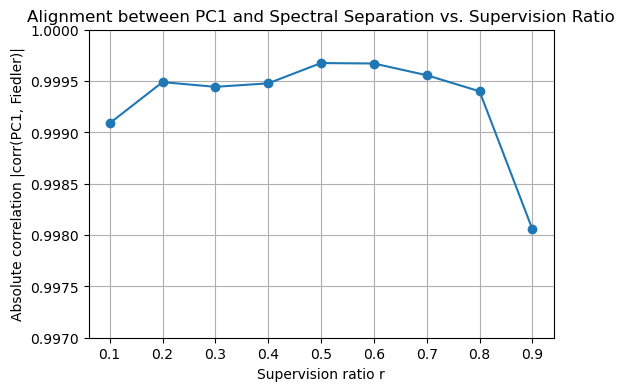

In [ ]:
# PCA plot 
# loop r from 0.1 to 0.9 and record the absolute correlation for each r
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

base_seed = 42
df_temp = df.copy()
y_all_indexed = df_temp["stance_binary"].values

r_list = [0.1 * i for i in range(1, 10)] 
corr_list = []

for r_val in r_list:
    test_size = 1.0 - r_val

    X_train_r, X_test_r, y_train_r, y_test_r, df_train_r, df_test_r = train_test_split(
        X_bert,
        y_all_indexed,
        df_temp,
        test_size=test_size,
        random_state=base_seed,
        stratify=y_all_indexed
    )
    clf = LogisticRegression(max_iter=2000, solver="liblinear")
    clf.fit(X_train_r, y_train_r)
    p_favor_test = clf.predict_proba(X_test_r)[:, 1]
    p_z = (p_favor_test - p_favor_test.mean()) / (p_favor_test.std() + 1e-8)
    stance_dim_test = (4.0 * p_z).reshape(-1, 1)
    X_test_aug = np.hstack([X_test_r, stance_dim_test])

    pca_sup_test = PCA(n_components=2, random_state=base_seed)
    X_test_aug_2d = pca_sup_test.fit_transform(X_test_aug)
    pc1_scores_sup = X_test_aug_2d[:, 0]

    gamma = 1.0 / X_test_aug.shape[1]
    A_test_aug = rbf_kernel(X_test_aug, gamma=gamma)
    L_sup = csgraph.laplacian(csr_matrix(A_test_aug), normed=True)
    eigvals_sup, u_sup = eigsh(L_sup, k=3, which="SM")
    idx_fiedler = np.argsort(eigvals_sup)[1]
    u2_sup = u_sup[:, idx_fiedler]

    correlation = np.abs(np.corrcoef(pc1_scores_sup, u2_sup)[0, 1])
    corr_list.append(correlation)

    print(f"r = {r_val:.1f} | abs corr(PC1, Fiedler) = {correlation:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(r_list, corr_list, marker='o')
plt.xlabel("Supervision ratio r")
plt.ylabel("Absolute correlation |corr(PC1, Fiedler)|")
plt.title("Alignment between PC1 and Spectral Separation vs. Supervision Ratio")
plt.ylim(0.997, 1)
plt.grid(True)
plt.show()


In [20]:
%%capture
# Section F: compre the augmented and the baseline model using label-efficiency curves
label_map = {"AGAINST": 0, "FAVOR": 1}
y_all = df["Stance"].map(label_map).values
X_all = X_bert
N = X_all.shape[0]
print("Total number of examples:", N)
train_ratios = np.linspace(0.01, 0.99, 99)
n_repeats = 10
base_seed = 50
sup_sil_mean, sup_sil_std = [], []
sup_lam_mean, sup_lam_std = [], []
sup_acc_mean, sup_acc_std = [], []
sup_Q_mean, sup_Q_std = [], []
base_sil_mean, base_sil_std = [], []
base_lam_mean, base_lam_std = [], []
base_acc_mean, base_acc_std = [], []
base_Q_mean, base_Q_std = [], []

# still, for all kinds of sample size.
for r in train_ratios:
    sup_sil_vals, sup_lam_vals, sup_acc_vals, sup_Q_vals = [], [], [], []
    base_sil_vals, base_lam_vals, base_acc_vals, base_Q_vals = [], [], [], []

    n_train = max(5, int(N * r))
    # print(f" global train_ratio = {r:.2f} (≈ {n_train} labels examples)")

    for rep in range(n_repeats):
        X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
            X_all,
            y_all,
            train_size=r,
            random_state=base_seed + rep,
            stratify=y_all
        )

        # baseline model bert
        gamma_base = 1.0 / X_test_r.shape[1]
        A_base = rbf_kernel(X_test_r, gamma=gamma_base)

        spec_base = SpectralClustering(
            n_clusters=2, affinity="precomputed", assign_labels="kmeans", random_state=42
        )
        clusters_base = spec_base.fit_predict(A_base)
        base_sil = silhouette_score(X_test_r, clusters_base)
        base_sil_vals.append(base_sil)
        L_base = csgraph.laplacian(csr_matrix(A_base), normed=True)
        eigvals_base, _ = eigsh(L_base, k=3, which="SM")
        base_lambda2 = float(np.sort(eigvals_base)[1])
        base_lam_vals.append(base_lambda2)
        k_deg_base = A_base.sum(axis=1)
        m_base = A_base.sum() / 2.0
        B_base = A_base - np.outer(k_deg_base, k_deg_base) / (2.0 * m_base)
        same_cluster_base = (clusters_base[:, None] == clusters_base[None, :])
        base_Q = (B_base * same_cluster_base).sum() / (2.0 * m_base)
        base_Q_vals.append(base_Q)
        y_pred_base = np.zeros_like(y_test_r)
        for c_id in np.unique(clusters_base):
            mask = (clusters_base == c_id)
            majority_is_favor = (y_test_r[mask].mean() > 0.5)
            y_pred_base[mask] = int(majority_is_favor)
        base_acc = accuracy_score(y_test_r, y_pred_base)
        base_acc_vals.append(base_acc)


        # augmented model bert + stance
        clf = LogisticRegression(max_iter=2000, solver="liblinear")
        clf.fit(X_train_r, y_train_r)
        p_test = clf.predict_proba(X_test_r)[:, 1]
        p_z = (p_test - p_test.mean()) / (p_test.std() + 1e-8)
        stance_dim = (4.0 * p_z).reshape(-1, 1)
        X_test_aug = np.hstack([X_test_r, stance_dim])

        gamma_aug = 1.0 / X_test_aug.shape[1]
        A_aug = rbf_kernel(X_test_aug, gamma=gamma_aug)

        spec_sup = SpectralClustering(
            n_clusters=2, affinity="precomputed", assign_labels="kmeans", random_state=42
        )
        clusters_sup = spec_sup.fit_predict(A_aug)
        sup_sil = silhouette_score(X_test_aug, clusters_sup)
        sup_sil_vals.append(sup_sil)
        L_sup = csgraph.laplacian(csr_matrix(A_aug), normed=True)
        eigvals_sup, _ = eigsh(L_sup, k=3, which="SM")
        sup_lambda2 = float(np.sort(eigvals_sup)[1])
        sup_lam_vals.append(sup_lambda2)
        k_deg_sup = A_aug.sum(axis=1)
        m_sup = A_aug.sum() / 2.0
        B_sup = A_aug - np.outer(k_deg_sup, k_deg_sup) / (2.0 * m_sup)
        same_cluster_sup = (clusters_sup[:, None] == clusters_sup[None, :])
        sup_Q = (B_sup * same_cluster_sup).sum() / (2.0 * m_sup)
        sup_Q_vals.append(sup_Q)
        y_pred_sup = np.zeros_like(y_test_r)
        for c_id in np.unique(clusters_sup):
            mask = (clusters_sup == c_id)
            majority_is_favor = (y_test_r[mask].mean() > 0.5)
            y_pred_sup[mask] = int(majority_is_favor)
        sup_acc = accuracy_score(y_test_r, y_pred_sup)
        sup_acc_vals.append(sup_acc)

    sup_sil_mean.append(np.mean(sup_sil_vals)); sup_sil_std.append(np.std(sup_sil_vals))
    sup_lam_mean.append(np.mean(sup_lam_vals)); sup_lam_std.append(np.std(sup_lam_vals))
    sup_acc_mean.append(np.mean(sup_acc_vals)); sup_acc_std.append(np.std(sup_acc_vals))
    sup_Q_mean.append(np.mean(sup_Q_vals)); sup_Q_std.append(np.std(sup_Q_vals))

    base_sil_mean.append(np.mean(base_sil_vals)); base_sil_std.append(np.std(base_sil_vals))
    base_lam_mean.append(np.mean(base_lam_vals)); base_lam_std.append(np.std(base_lam_vals))
    base_acc_mean.append(np.mean(base_acc_vals)); base_acc_std.append(np.std(base_acc_vals))
    base_Q_mean.append(np.mean(base_Q_vals)); base_Q_std.append(np.std(base_Q_vals))

sup_sil_mean, sup_sil_std = np.array(sup_sil_mean), np.array(sup_sil_std)
sup_lam_mean, sup_lam_std = np.array(sup_lam_mean), np.array(sup_lam_std)
sup_acc_mean, sup_acc_std = np.array(sup_acc_mean), np.array(sup_acc_std)
sup_Q_mean, sup_Q_std = np.array(sup_Q_mean), np.array(sup_Q_std)

base_sil_mean, base_sil_std = np.array(base_sil_mean), np.array(base_sil_std)
base_lam_mean, base_lam_std = np.array(base_lam_mean), np.array(base_lam_std)
base_acc_mean, base_acc_std = np.array(base_acc_mean), np.array(base_acc_std)
base_Q_mean, base_Q_std = np.array(base_Q_mean), np.array(base_Q_std)

def smooth_with_ci(x_percent, mean_vals, std_vals, n_repeats, num_points=400):
    se = std_vals / np.sqrt(n_repeats)
    ci_low = mean_vals - 1.96 * se
    ci_high = mean_vals + 1.96 * se
    x = np.array(x_percent)
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    mean_spline = make_interp_spline(x, mean_vals, k=3)
    low_spline = make_interp_spline(x, ci_low, k=3)
    high_spline = make_interp_spline(x, ci_high, k=3)
    y_mean = mean_spline(x_smooth)
    y_low = low_spline(x_smooth)
    y_high = high_spline(x_smooth)
    return x_smooth, y_mean, y_low, y_high

x_percent = train_ratios * 100

x_sup_Q, y_sup_Q, y_sup_Q_low, y_sup_Q_high = smooth_with_ci(x_percent, sup_Q_mean, sup_Q_std, n_repeats)
x_sup_acc, y_sup_acc, y_sup_acc_low, y_sup_acc_high = smooth_with_ci(x_percent, sup_acc_mean, sup_acc_std, n_repeats)
x_base_Q, y_base_Q, y_base_Q_low, y_base_Q_high = smooth_with_ci(x_percent, base_Q_mean, base_Q_std, n_repeats)
x_base_acc, y_base_acc, y_base_acc_low, y_base_acc_high = smooth_with_ci(x_percent, base_acc_mean, base_acc_std, n_repeats)

In [21]:
%%capture
# Section F: Label-efficiency curves, still we will use the ratios before
label_map = {"AGAINST": 0, "FAVOR": 1}
y_all = df["Stance"].map(label_map).values
X_all = X_bert
N = X_all.shape[0]

print("Total number of examples:", N)
train_ratios = np.linspace(0.01, 0.99, 99)
n_repeats = 10

sil_mean, sil_std = [], []
lam_mean, lam_std = [], []
acc_mean, acc_std = [], []
ari_mean, ari_std = [], []
Q_mean,  Q_std  = [], []

base_seed = 123456

for r in train_ratios:
    sil_vals = []
    lam_vals = []
    acc_vals = []
    ari_vals = []
    Q_vals   = []

    n_train = max(5, int(N * r))
    print(f"\nGlobal train_ratio = {r:.2f} (≈ {n_train} labeled examples)")

    for rep in range(n_repeats):
        X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
            X_all,
            y_all,
            train_size=r,
            random_state=base_seed + rep,
            stratify=y_all
        )

        clf = LogisticRegression(max_iter=2000, solver="liblinear")
        clf.fit(X_train_r, y_train_r)

        p_test = clf.predict_proba(X_test_r)[:, 1]
        p_z = (p_test - p_test.mean()) / (p_test.std() + 1e-8)
        stance_dim = (4.0 * p_z).reshape(-1, 1)
        X_test_aug = np.hstack([X_test_r, stance_dim])
        gamma = 1.0 / X_test_aug.shape[1]
        A = rbf_kernel(X_test_aug, gamma=gamma)

        spec = SpectralClustering(
            n_clusters=2,
            affinity="precomputed",
            assign_labels="kmeans",
            random_state=42
        )
        clusters = spec.fit_predict(A)
        sil = silhouette_score(X_test_aug, clusters)
        sil_vals.append(sil)
        L = csgraph.laplacian(csr_matrix(A), normed=True)
        eigvals, _ = eigsh(L, k=3, which="SM")
        lambda2 = float(np.sort(eigvals)[1])
        lam_vals.append(lambda2)
        y_pred_cluster = np.zeros_like(y_test_r)
        for c_id in np.unique(clusters):
            mask = (clusters == c_id)
            majority_is_favor = (y_test_r[mask].mean() > 0.5)
            label_c = int(majority_is_favor)  # 1 for FAVOR, 0 for AGAINST
            y_pred_cluster[mask] = label_c

        acc = accuracy_score(y_test_r, y_pred_cluster)
        acc_vals.append(acc)
        ari = adjusted_rand_score(y_test_r, clusters) # ari
        ari_vals.append(ari)

        k_deg = A.sum(axis=1)
        m = A.sum() / 2.0
        B = A - np.outer(k_deg, k_deg) / (2.0 * m)
        same_cluster = (clusters[:, None] == clusters[None, :])
        Q = (B * same_cluster).sum() / (2.0 * m)
        Q_vals.append(Q)

    sil_mean.append(np.mean(sil_vals))
    sil_std.append(np.std(sil_vals))

    lam_mean.append(np.mean(lam_vals))
    lam_std.append(np.std(lam_vals))

    acc_mean.append(np.mean(acc_vals))
    acc_std.append(np.std(acc_vals))

    ari_mean.append(np.mean(ari_vals))
    ari_std.append(np.std(ari_vals))

    Q_mean.append(np.mean(Q_vals))
    Q_std.append(np.std(Q_vals))
sil_mean = np.array(sil_mean)
sil_std  = np.array(sil_std)
lam_mean = np.array(lam_mean)
lam_std  = np.array(lam_std)
acc_mean = np.array(acc_mean)
acc_std  = np.array(acc_std)
ari_mean = np.array(ari_mean)
ari_std  = np.array(ari_std)
Q_mean   = np.array(Q_mean)
Q_std    = np.array(Q_std)

def smooth_with_ci(x_percent, mean_vals, std_vals, n_repeats, num_points=400):
    se = std_vals / np.sqrt(n_repeats)
    ci_low = mean_vals - 1.96 * se
    ci_high = mean_vals + 1.96 * se

    x = np.array(x_percent)
    x_smooth = np.linspace(x.min(), x.max(), num_points)

    mean_spline = make_interp_spline(x, mean_vals, k=3)
    low_spline  = make_interp_spline(x, ci_low,  k=3)
    high_spline = make_interp_spline(x, ci_high, k=3)

    y_mean = mean_spline(x_smooth)
    y_low  = low_spline(x_smooth)
    y_high = high_spline(x_smooth)
    return x_smooth, y_mean, y_low, y_high

x_percent = train_ratios * 100

x_sil, y_sil, y_sil_low, y_sil_high = smooth_with_ci(x_percent, sil_mean, sil_std, n_repeats)
x_lam, y_lam, y_lam_low, y_lam_high = smooth_with_ci(x_percent, lam_mean, lam_std, n_repeats)
x_acc, y_acc, y_acc_low, y_acc_high = smooth_with_ci(x_percent, acc_mean, acc_std, n_repeats)
x_ari, y_ari, y_ari_low, y_ari_high = smooth_with_ci(x_percent, ari_mean, ari_std, n_repeats)
x_Q,   y_Q,   y_Q_low,   y_Q_high   = smooth_with_ci(x_percent, Q_mean,   Q_std,   n_repeats)


<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-279439834.py:20: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_lam, y_lam, linewidth=2, label="Mean $\lambda_2$")
/tmp/ipython-input-279439834.py:22: SyntaxWarning: invalid escape sequence '\l'
  plt.title("Fiedler value $\lambda_2$ vs. Supervision")
/tmp/ipython-input-279439834.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel("Fiedler value $\lambda_2$")


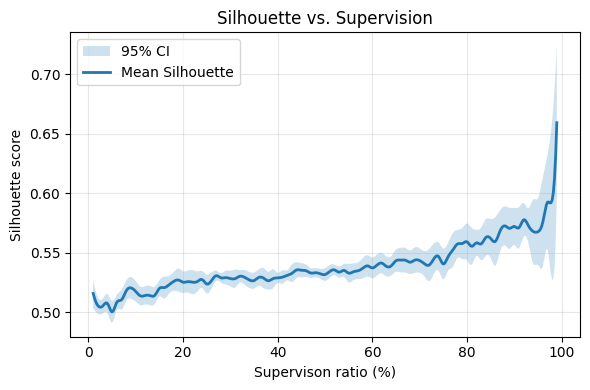

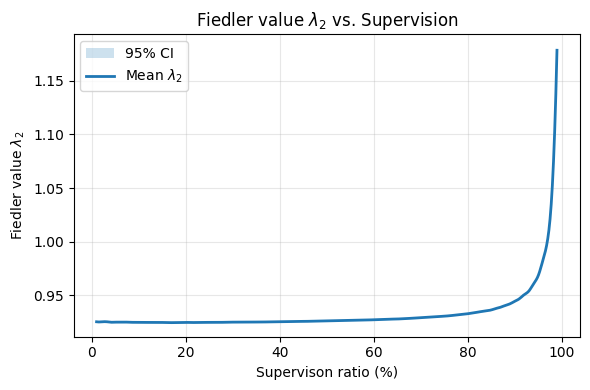

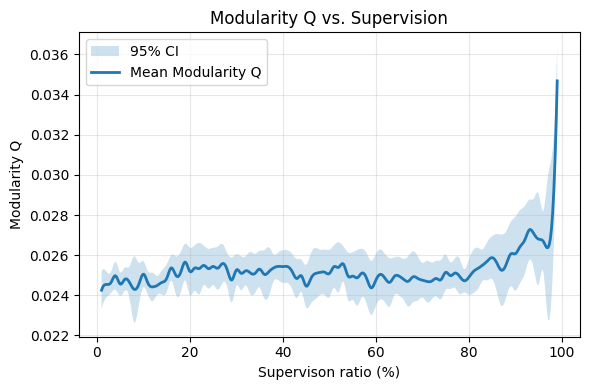

In [22]:
# compre: sil value and the supervision use
plt.figure(figsize=(6, 4))
xticks = np.linspace(0, 100, 6)

plt.fill_between(x_sil, y_sil_low, y_sil_high, alpha=0.22, label="95% CI")
plt.plot(x_sil, y_sil, linewidth=2, label="Mean Silhouette")

plt.title("Silhouette vs. Supervision")
plt.xlabel("Supervison ratio (%)")
plt.ylabel("Silhouette score")
plt.grid(alpha=0.3)
plt.xticks(xticks)
plt.legend()
plt.tight_layout()
plt.show()

# f value and supervision use
plt.figure(figsize=(6, 4))
plt.fill_between(x_lam, y_lam_low, y_lam_high, alpha=0.22, label="95% CI")
plt.plot(x_lam, y_lam, linewidth=2, label="Mean $\lambda_2$")

plt.title("Fiedler value $\lambda_2$ vs. Supervision")
plt.xlabel("Supervison ratio (%)")
plt.ylabel("Fiedler value $\lambda_2$")
plt.grid(alpha=0.3)
plt.xticks(xticks)
plt.legend()
plt.tight_layout()
plt.show()
# modularity Q and supervision use
plt.figure(figsize=(6, 4))
plt.fill_between(x_Q, y_Q_low, y_Q_high, alpha=0.22, label="95% CI")
plt.plot(x_Q, y_Q, linewidth=2, label="Mean Modularity Q")
plt.title("Modularity Q vs. Supervision")
plt.xlabel("Supervison ratio (%)")
plt.ylabel("Modularity Q")
plt.grid(alpha=0.3)
plt.xticks(xticks)
plt.legend()
plt.tight_layout()
plt.show()


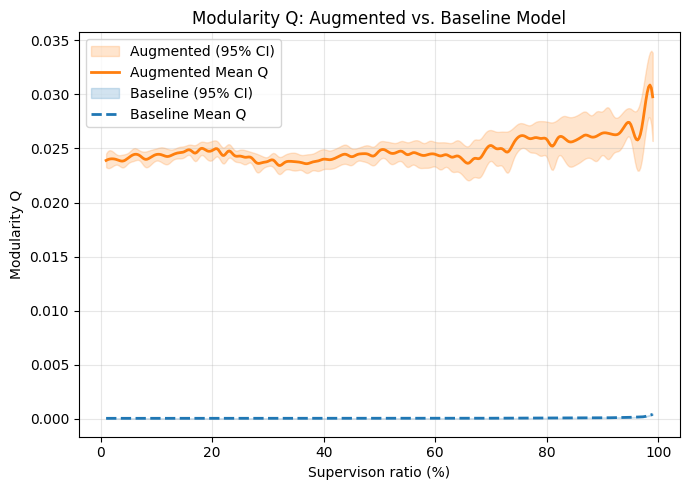

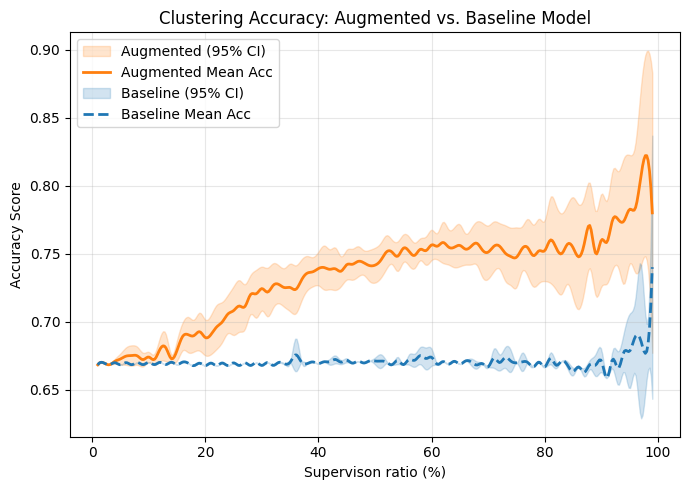

In [ ]:
# modularity Q comparison, this is the intrinsci
plt.figure(figsize=(7, 5))
xticks = np.linspace(0, 100, 6)
# aug model and baseline model
plt.fill_between(x_sup_Q, y_sup_Q_low, y_sup_Q_high, alpha=0.2, label="Augmented (95% CI)", color='tab:orange')
plt.plot(x_sup_Q, y_sup_Q, linewidth=2, label="Augmented Mean Q", color='tab:orange')
plt.fill_between(x_base_Q, y_base_Q_low, y_base_Q_high, alpha=0.2, label="Baseline (95% CI)", color='tab:blue')
plt.plot(x_base_Q, y_base_Q, linewidth=2, label="Baseline Mean Q", color='tab:blue', linestyle='--')
plt.title("Modularity Q: Augmented vs. Baseline Model")
plt.xlabel("Supervison ratio (%)")
plt.ylabel("Modularity Q")
plt.grid(alpha=0.3)
plt.xticks(xticks)
plt.legend()
plt.tight_layout()
plt.show()

# accuracy compre, this is the extrinsic utility avaluation
plt.figure(figsize=(7, 5))
# aug model and baseline model
plt.fill_between(x_sup_acc, y_sup_acc_low, y_sup_acc_high, alpha=0.2, label="Augmented (95% CI)", color='tab:orange')
plt.plot(x_sup_acc, y_sup_acc, linewidth=2, label="Augmented Mean Acc", color='tab:orange')
plt.fill_between(x_base_acc, y_base_acc_low, y_base_acc_high, alpha=0.2, label="Baseline (95% CI)", color='tab:blue')
plt.plot(x_base_acc, y_base_acc, linewidth=2, label="Baseline Mean Acc", color='tab:blue', linestyle='--')
plt.title("Clustering Accuracy: Augmented vs. Baseline Model")
plt.xlabel("Supervison ratio (%)")
plt.ylabel("Accuracy Score")
plt.grid(alpha=0.3)
plt.xticks(xticks)
plt.legend()
plt.tight_layout()
plt.show()